## Load synthetic InSAR Data and compare to Observations
To be run in environment `seissol`

This notebook is an adaptation of Mathilde's adaptation (`compare_geodqeticMM_mathilde-original.py`) of Thomas's code. 

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import geopandas as gpd
import os
import shapefile as shp
import rasterio
import seissolxdmf
import time
from scipy import spatial
from multiprocessing import Pool, cpu_count, Manager
from pyproj import Transformer
from cmcrameri import cm
import matplotlib
from rasterio.plot import show
import scipy.interpolate as interp
import xarray as xr
import pygmt

ps = 12 # set font size
matplotlib.rcParams.update({"font.size": ps})
plt.rcParams["font.family"] = "sans"
matplotlib.rc("xtick", labelsize=ps)
matplotlib.rc("ytick", labelsize=ps)


## Define Functions

In [34]:
def nanrms(x, axis=None):
    return np.sqrt(np.nanmean(x**2, axis=axis))

def setup_map(ax,extentmap,gridlines_left=True, draw_labels=True):
    """Setup the background map with cartopy"""
    ax.set_extent(extentmap, crs=ccrs.PlateCarree())
    scale = "10m"
    ax.add_feature(cfeature.LAND.with_scale(scale), facecolor='whitesmoke', rasterized=True)
    ax.add_feature(cfeature.OCEAN.with_scale(scale), rasterized=True)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale))
    ax.add_feature(cfeature.BORDERS.with_scale(scale), linestyle=":")
    locs = np.arange(-180, 180, 1.0)
    gl = ax.gridlines(draw_labels=draw_labels, ylocs=locs, xlocs=locs)
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = gridlines_left
    for fn in [
        "/Users/hyin/agsd/projects/insar/2021_haiti/dynamic-rupture/fault-geometry/combined-drm-geometry_v05/combined-drm-geometry_v05.shp" # shape file with fault traces, each as a line object
    ]:
        sf = shp.Reader(fn)
        for sr in sf.shapeRecords():    # for each fualt?
            listx = []
            listy = []
            for xNew, yNew in sr.shape.points:
                listx.append(xNew)
                listy.append(yNew)
            ax.plot(listx, listy, "k", linewidth=0.5)

def read_observation_data_one_band(fn):
    with rasterio.open(fn) as src:
        ew = src.read(1)
        print("band 1 has shape", ew.shape)
        ds = downsampling
        height, width = ew.shape
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        lon_g, lat_g = rasterio.transform.xy(src.transform, rows, cols)
        lon_g = np.array(lon_g)[::ds, ::ds]
        lat_g = np.array(lat_g)[::ds, ::ds]
        ew = ew[::ds, ::ds]
        return lon_g, lat_g, ew


def compute_LOS_displacement_SeisSol_data(
    lon_g, lat_g, theta_g, phi_g, lonlat_barycenter, U, V, W
):

    if band == "azimuth":
        D_los = U * np.sin(phi_g) + V * np.cos(phi_g)
    else:
        D_los = W * np.cos(theta_g) + np.sin(theta_g) * (
            U * -np.cos(phi_g) + V * np.sin(phi_g)
        )
        # D_los = W * np.sin(theta_inter) + np.cos(theta_inter) * (U * np.cos(phi_inter) + V * np.sin(phi_inter))
    return -D_los

def compute_LOS_displacement_SeisSol_data2(lon_g, lat_g, vx, vy, vz, lonlat_barycenter, U,V,W):
    D_los = U * vx + V * vy + W * vz
    return -D_los
    
    
def read_seissol_surface_data(xdmfFilename):
    """
    Read unstructured free surface output and associated data.
    compute cell_barycenter
    
    
    Parameters
    ----------
    xdmfFilename : string
        Full path to the .xdmf file

    Returns
    -------
    lons, lats, lonlat_barycenter, connect, U, V, W
    lons, lats: n x 1 array the locations of each grid point where surface deformation is defined in the model. 
        I believe this is in WGS84 but need to check
        Where n is the number of points in the surface mesh
        i.e. for Haiti low res mesh this is (16347,)
    lonlat_barycenter: n x 2 array where each column is the lon and lat coords of the barycenter of a triangle
        Where n is the number of triangles (need to check this!)
        i.e. for Haiti low res mesh this is (32526, 2)
    connect: n x 3 array, where the columns contain indices for the corners of each triangle at the surface
    U, V, W: each are an nd-array where each is a component of modeled surface deformation:
        U = u1
        V = u2
        W = u3
    """
    sx = seissolxdmf.seissolxdmf(xdmfFilename)

    xyz = sx.ReadGeometry()
    connect = sx.ReadConnect()
    U = sx.ReadData("u1", sx.ndt - 1)
    V = sx.ReadData("u2", sx.ndt - 1)
    W = sx.ReadData("u3", sx.ndt - 1)
    # project the data to geocentric (lat, lon)

    # myproj = "+proj=tmerc +datum=WGS84 +k=0.9996 +lon_0=37.0 +lat_0=37.0"
    # UTM =  'epgs:32618'
    # WGS84 = "epsg:4326"
    transformer = Transformer.from_crs("epsg:32618", "epsg:4326", always_xy=True)
    lons, lats = transformer.transform(xyz[:, 0], xyz[:, 1])    # 
    xy = np.vstack((lons, lats)).T  # gives a grid of lon,lat values, need to check the format

    # compute triangule barycenter
    lonlat_barycenter = (
        xy[connect[:, 0], :] + xy[connect[:, 1], :] + xy[connect[:, 2], :]
    ) / 3.0

    return lons, lats, lonlat_barycenter, connect, U, V, W

def interpolate_seissol_surf_output(lonlat_barycenter, U, V , W, df):
    """interpolate SeisSol free surface output to GPS data location"""

    Fvsm = interp.LinearNDInterpolator(lonlat_barycenter, U)
    locGPS = np.vstack((df["lon"].to_numpy(), df["lat"].to_numpy())).T

    Fvsm = interp.LinearNDInterpolator(lonlat_barycenter, U)
    ui = Fvsm.__call__(locGPS)
    Fvsm = interp.LinearNDInterpolator(lonlat_barycenter, V)
    vi = Fvsm.__call__(locGPS)
    Fvsm = interp.LinearNDInterpolator(lonlat_barycenter, W)
    wi = Fvsm.__call__(locGPS)

    return ui, vi, wi

## Read in InSAR Observation data
And define a set of observation points that we will want to use later

In [10]:
## Read in InSAR observation data from a CSV
# Write to geodataframe, with lon / lat fields as geometry
# Set geometry reference frame as WGS84

datadir = '/Users/hyin/agsd/projects/insar/2021_haiti/dynamic-rupture/observation-data/insar/data/csv/'
filebase = '/A2_A042_20210101-20210827_los'
df = pd.read_csv(datadir+filebase+'.csv')

## Write to a geopandas dataframe, do not need this for now. 
# gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df.lon, df.lat, df.elevation, crs="EPSG:4326"), data=df)

# Create an array with lons and lats of observations locations for later use. 
lon_obs, lat_obs = df.lon.array, df.lat.array
locData = np.vstack((lon_obs,lat_obs)).T
# locData.shape

# Convert observation data to an xarray DataSet
obs_ds = xr.Dataset.from_dataframe(df.set_index(['lat', 'lon']))
# Convert "los_mm" from millimeters to meters
obs_ds['los_mm'] = obs_ds['los_mm'] / 1000
# Rrename the variable to reflect the new unit
obs_ds = obs_ds.rename({'los_mm': 'los_m'})

## Save as .nc file for later use if needed. 
# obs_ds.to_netcdf(datadir + filebase + '.nc')


## Read in Synthetic Data

In [11]:
# Define SeisSol surface XDMF file
xdmfFilename = '/Users/hyin/ags_local/data/haiti_seissol_data/FL33_dynamic-relaxation/jobid_3437317/FL33_jobid_3437317_output_extracted-surface.xdmf'
# Extract the directory path and filename
path, filename = os.path.split(xdmfFilename)
# Extract the filebase by removing the extension
filebase, _ = os.path.splitext(filename)

# Output the results
print(f"path: {path}")
print(f"filebase: {filebase}")

# Read Modeled surface deformation data from surface xdmf
vertex_lon, vertex_lat, lonlat_barycenter, connect, U, V, W=read_seissol_surface_data(xdmfFilename)
lonlat_barycenter[:, 0] = lonlat_barycenter[:, 0] + 360
# There are 32526 triangles and 16347 vertices
# latlon_barycenter is a (32526,2) array, with lat and lon for every triangle
# U, V, W are (32526,) arrays
# vertex_lon and vertex_lat are (16347,) arrays

# ## Interpolate modeled data at each observed point
# Where df is the dataframe with InSAR observation points
x_synth_i, y_synth_i, z_synth_i = interpolate_seissol_surf_output(lonlat_barycenter, U, V , W, df)

path: /Users/hyin/ags_local/data/haiti_seissol_data/FL33_dynamic-relaxation/jobid_3437317
filebase: FL33_jobid_3437317_output_extracted-surface


(27552,)

In [22]:
sx = seissolxdmf.seissolxdmf(xdmfFilename)

8

In [12]:
# df.to_csv(path +'/'+ filebase + '.csv')

# Convert arrays to a pandas dataframe
synth_df = pd.DataFrame({
    'lat': df['lat'],
    'lon': df['lon'],
    'x_synth_i': x_synth_i.flatten(),
    'y_synth_i': y_synth_i.flatten(),
    'z_synth_i': z_synth_i.flatten()
})

# Convert gdf to xarray 
synth_ds = xr.Dataset.from_dataframe(synth_df.set_index(['lat', 'lon']))
synth_ds


<xarray.Dataset> Size: 664kB
Dimensions:    (lat: 164, lon: 168)
Coordinates:
  * lat        (lat) float64 1kB 18.17 18.18 18.18 18.19 ... 18.9 18.9 18.91
  * lon        (lon) float64 1kB 286.2 286.2 286.2 286.2 ... 287.0 287.0 287.0
Data variables:
    x_synth_i  (lat, lon) float64 220kB 0.03077 0.03413 ... -0.06153 -0.06089
    y_synth_i  (lat, lon) float64 220kB 0.2181 0.2155 0.213 ... -0.05649 -0.0553
    z_synth_i  (lat, lon) float64 220kB 0.007474 0.01196 ... -0.01771 -0.0177

## Merge the synthetic dataset with the observation dataset into a MEGADATASET 

In [26]:
merged_ds = obs_ds.assign(x_synth_i=synth_ds['x_synth_i'],y_synth_i=synth_ds['y_synth_i'], z_synth_i=synth_ds['z_synth_i'])
merged_ds['look_U'].mean()

<xarray.DataArray 'look_U' ()> Size: 8B
array(0.8540913)

## Calculate synthetic LOS vectors

In [27]:
# Calculate LOS vectors 
# Element-by-element addition
merged_ds['los_synth_m'] = merged_ds['x_synth_i']*merged_ds['look_E'] + merged_ds['y_synth_i']*merged_ds['look_N'] + merged_ds['z_synth_i']*merged_ds['look_U']
merged_ds['los_diff'] = merged_ds['los_m'] - merged_ds['los_synth_m']
merged_ds

<xarray.Dataset> Size: 2MB
Dimensions:      (lat: 164, lon: 168)
Coordinates:
  * lat          (lat) float64 1kB 18.17 18.18 18.18 18.19 ... 18.9 18.9 18.91
  * lon          (lon) float64 1kB 286.2 286.2 286.2 286.2 ... 287.0 287.0 287.0
Data variables:
    Unnamed: 0   (lat, lon) int64 220kB 27384 27385 27386 27387 ... 165 166 167
    elevation    (lat, lon) float64 220kB -93.55 -102.5 -102.5 ... -271.1 -271.1
    look_E       (lat, lon) float64 220kB -0.4528 -0.4534 ... -0.5614 -0.5619
    look_N       (lat, lon) float64 220kB -0.08912 -0.08923 ... -0.1074 -0.1074
    look_U       (lat, lon) float64 220kB 0.8871 0.8868 0.8865 ... 0.8206 0.8202
    los_m        (lat, lon) float64 220kB nan nan nan nan ... nan nan nan nan
    x_synth_i    (lat, lon) float64 220kB 0.03077 0.03413 ... -0.06153 -0.06089
    y_synth_i    (lat, lon) float64 220kB 0.2181 0.2155 ... -0.05649 -0.0553
    z_synth_i    (lat, lon) float64 220kB 0.007474 0.01196 ... -0.01771 -0.0177
    los_synth_m  (lat, lon) float64 220kB -0.02674 -0.0241 ... 0.02607 0.02564
    los_diff     (lat, lon) float64 220kB nan nan nan nan ... nan nan nan nan

## Plot the Results
Working, tested single panel plot in the cell below

/Users/hyin/miniconda3/envs/seissol/lib/python3.12/site-packages/pygmt/clib/session.py:1498: RuntimeWarning: Grid may have irregular spacing in the 'lon' dimension, but GMT only supports regular spacing. Calculated regular spacing 0.004737101796407077 is assumed in the 'lon' dimension.
  matrix, region, inc = dataarray_to_matrix(grid)
/Users/hyin/miniconda3/envs/seissol/lib/python3.12/site-packages/pygmt/clib/session.py:1498: RuntimeWarning: Grid may have irregular spacing in the 'lat' dimension, but GMT only supports regular spacing. Calculated regular spacing 0.004496950920245399 is assumed in the 'lat' dimension.
  matrix, region, inc = dataarray_to_matrix(grid)


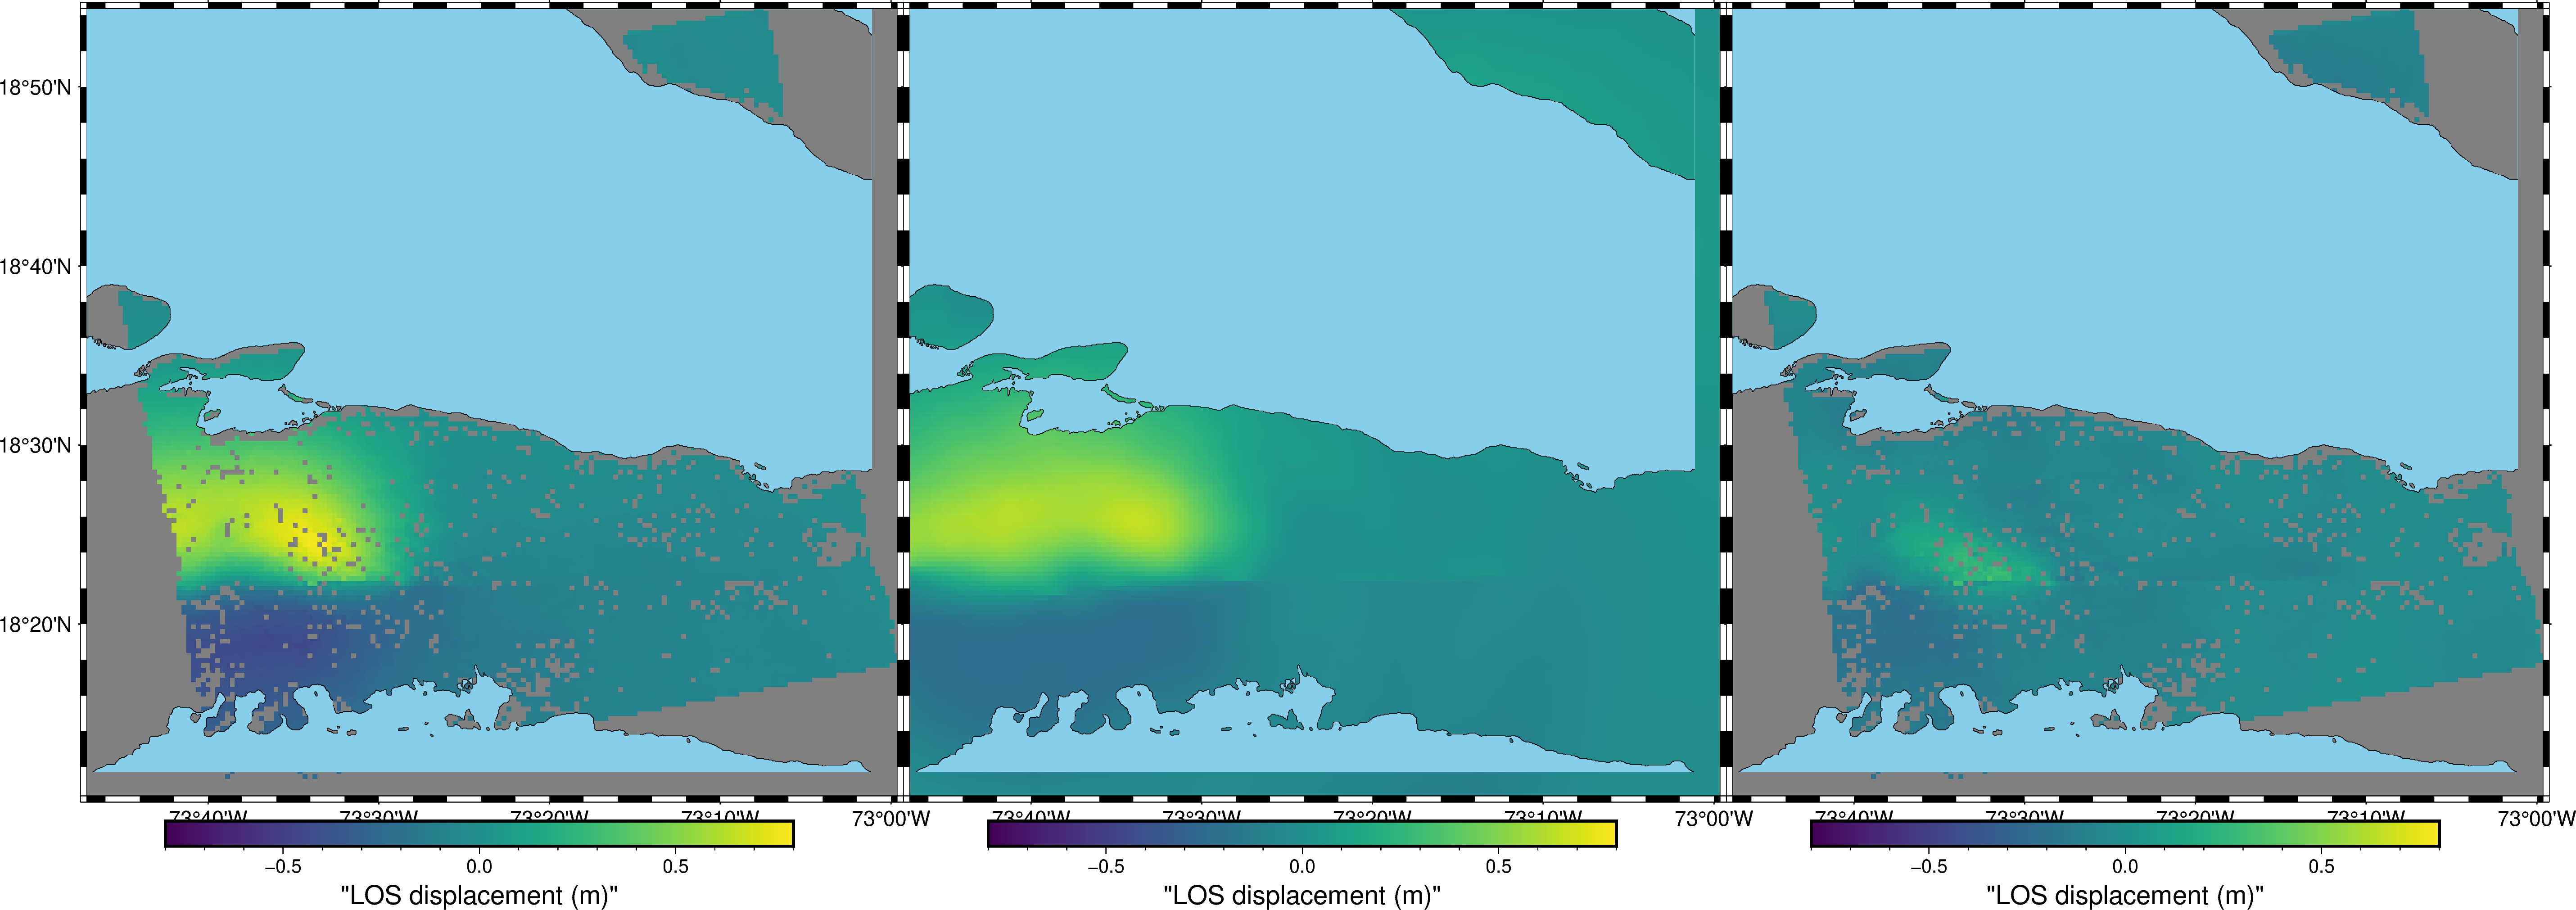

In [32]:
# Set up the PyGMT figure with two panels
import pygmt
fig = pygmt.Figure()


pygmt.makecpt(cmap="viridis", series=[-0.8, 0.8])

# Define the layout for a 1-row, 2-column subplot
with fig.subplot(nrows=1, ncols=3, figsize=("18i", "6i"), sharex="b", sharey="l", frame="a"):
    
    # Left Panel: Observed LOS data
    with fig.set_panel(panel=0):
        fig.grdimage(grid=merged_ds['los_m'], projection='M6i', frame=True, cmap=True)
        fig.coast(shorelines=True, water='skyblue')
        fig.colorbar(frame='af+l"LOS displacement (m)"')
    
    # Middle Panel: Synthetic LOS data
    with fig.set_panel(panel=1):
        fig.grdimage(grid=merged_ds['los_synth_m'], projection='M6i', frame=True, cmap=True)
        fig.coast(shorelines=True, water='skyblue')
        fig.colorbar(frame='af+l"LOS displacement (m)"')

    # Right Panel: Residual (los_m - los_synth_m)
    with fig.set_panel(panel=2):
        fig.grdimage(grid=merged_ds['los_diff'], projection='M6i', frame=True, cmap=True)
        fig.coast(shorelines=True, water='skyblue')
        fig.colorbar(frame='af+l"LOS displacement (m)"')

# Show the figure
fig.show()


/Users/hyin/miniconda3/envs/seissol/lib/python3.12/site-packages/pygmt/clib/session.py:1498: RuntimeWarning: Grid may have irregular spacing in the 'lon' dimension, but GMT only supports regular spacing. Calculated regular spacing 0.0047335616438356565 is assumed in the 'lon' dimension.
  matrix, region, inc = dataarray_to_matrix(grid)
/Users/hyin/miniconda3/envs/seissol/lib/python3.12/site-packages/pygmt/clib/session.py:1498: RuntimeWarning: Grid may have irregular spacing in the 'lat' dimension, but GMT only supports regular spacing. Calculated regular spacing 0.0044871782945736325 is assumed in the 'lat' dimension.
  matrix, region, inc = dataarray_to_matrix(grid)


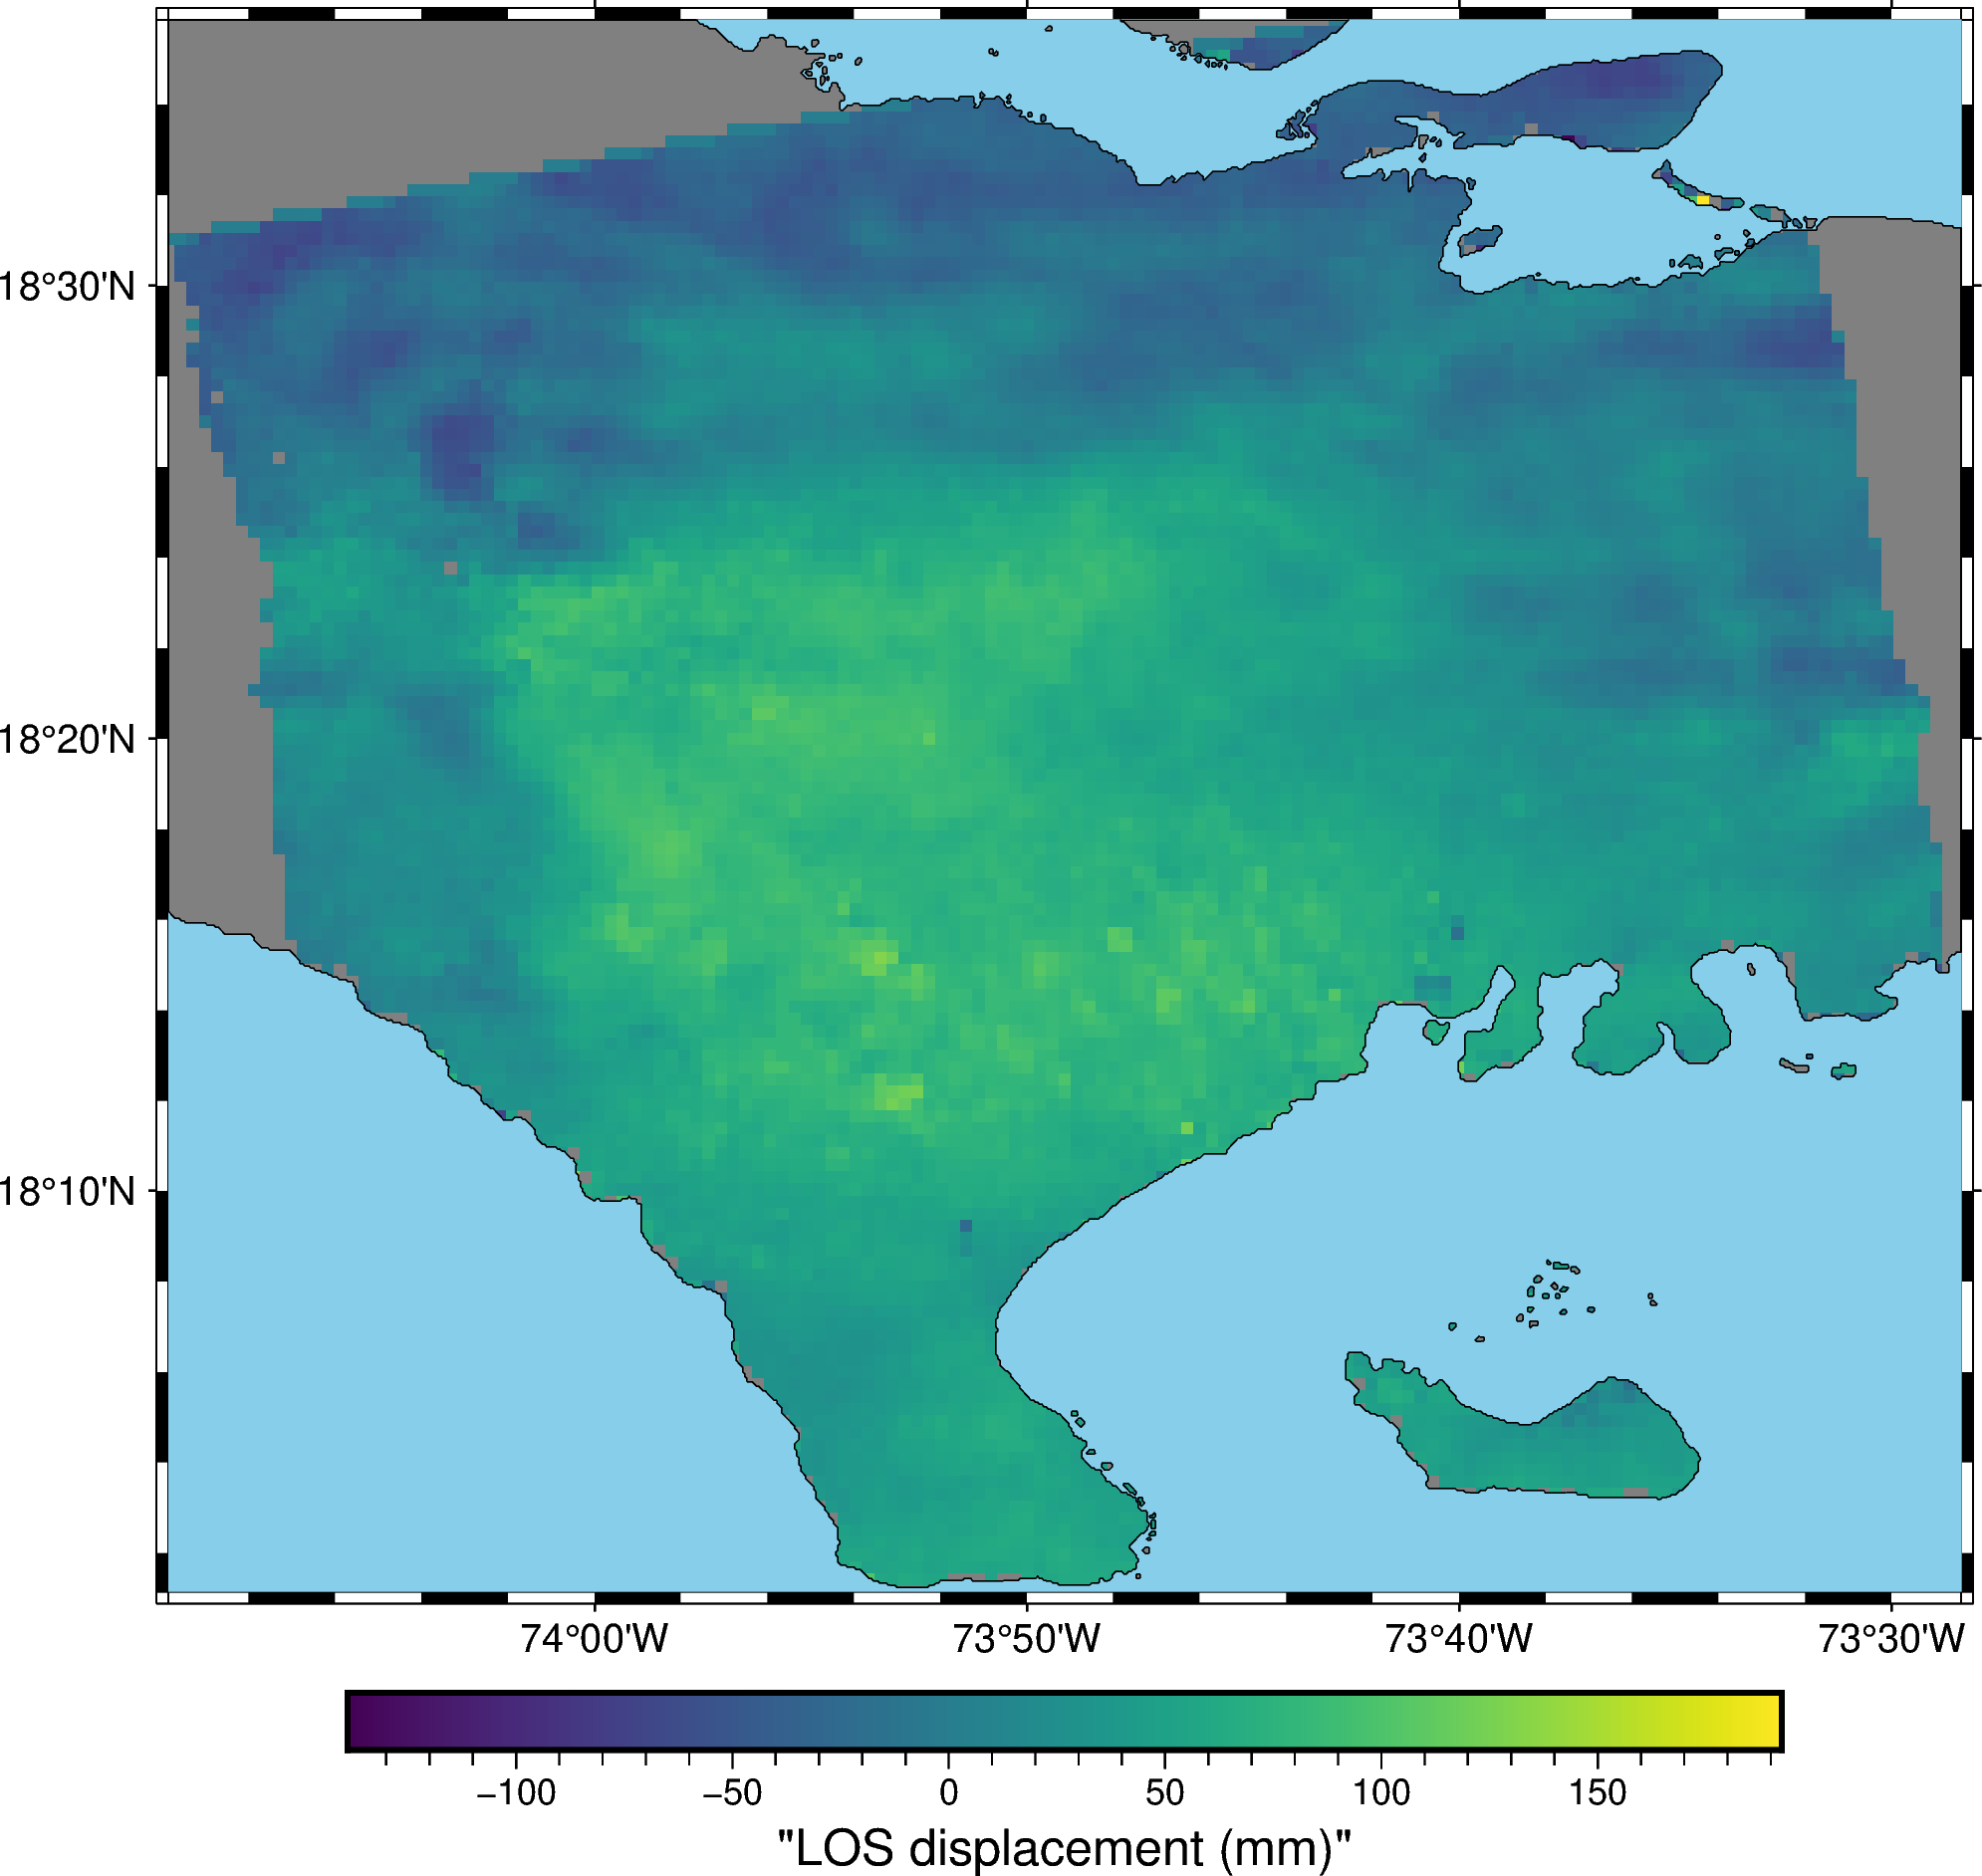

In [35]:
## chatgpt plot obs data

import pandas as pd
import xarray as xr
import pygmt

# Load the CSV file into a Pandas DataFrame
file_path = datadir+filebase+'.csv'
df = pd.read_csv(file_path)

# Pivot the DataFrame to create a grid of 'lat' vs 'lon'
# This assumes that the data is on a regular grid
df_pivot = df.pivot(index='lat', columns='lon', values='los_mm')

# Convert the pivoted DataFrame to an xarray DataArray
data_array = xr.DataArray(
    data=df_pivot.values,
    coords={
        'lat': df_pivot.index.values,
        'lon': df_pivot.columns.values
    },
    dims=['lat', 'lon']
)

# Set up the PyGMT figure
fig = pygmt.Figure()

# Plot the gridded LOS data using grdimage
fig.grdimage(grid=data_array, projection='M6i', frame=True, cmap='viridis')

# Add coastlines for context
fig.coast(shorelines=True, water='skyblue')

# Add a color bar to indicate LOS displacement values
fig.colorbar(frame='af+l"LOS displacement (mm)"')

# Show the figure
fig.show()

In [34]:
import pandas as pd
import xarray as xr
import pygmt

# Load the CSV file into a Pandas DataFrame
file_path = datadir+filebase+'.csv'
df = pd.read_csv(file_path)

# Pivot the DataFrame to create a grid of 'lat' vs 'lon'
# This assumes that the data is on a regular grid
df_pivot = df.pivot(index='lat', columns='lon', values='los_mm')

# Convert the pivoted DataFrame to an xarray DataArray
data_array = xr.DataArray(
    data=df_pivot.values,
    coords={
        'lat': df_pivot.index.values,
        'lon': df_pivot.columns.values
    },
    dims=['lat', 'lon']
)

# Set up the PyGMT figure
fig = pygmt.Figure()

In [30]:
# Plot observation data
import pygmt
extentmap=[-74.6, -72.2, 17.9, 19]
projection = 'M0/0/20c'

# Set up the figure
fig = pygmt.Figure()

# # Plot the LOS data using a color palette
# fig.basemap(region=extentmap,projection='M6i', frame=True)
# fig.coast(shorelines=True, water='skyblue', resolution='i')

cpt = [-3,3,0.1]
pygmt.makecpt(cmap="vik", series=cpt)
fig.basemap(region=extentmap, projection=projection, frame=["a0.5f0.1"])

fig.grdimage(
    grid=obs_da,
    projection=projection,
    cmap=True,
    transparency=30
)
# Plot the LOS values as colored points
# fig.plot(x=df['lon'], y=df['lat'], color=df['los_mm'],
#          cmap='viridis', style='c0.1c', pen='black')


# Add color bar for LOS values
fig.colorbar(frame='af+l"LOS displacement (mm)"')

# Show the figure
fig.show()

GMTInvalidInput: Invalid number of grid dimensions '1'. Must be 2.

AttributeError: 'DataFrame' object has no attribute 'view'

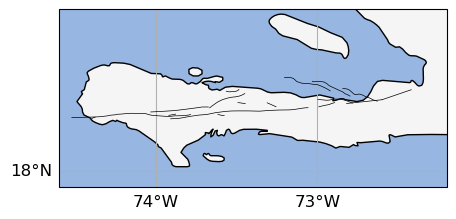

In [18]:
# Plot figure
vmax = 4.0
vmin = -vmax
# if band in ["azimuth", "range"]:
#     extentmap=[36.6, 38.4, 36.7, 38.2]

# set map extent 
extentmap=[-74.6, -72.2, 17.9, 19]

fig = plt.figure()
fig.set_size_inches(5, 4.5)
ax = []
ax.append(fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()))
setup_map(ax[0],extentmap)
show(df, cmap=cm.vik,vmin=vmin,vmax=vmax)

## Misc
Everything below here was worked on at various times and is now under construction

Let's start by trying to understand how to read and look at the xdmf surface data
Then we can adjust the InSAR data as needed and see if we can leverage existing workflows for .grd data 

In [62]:
xdmfFilename = '/Users/hyin/agsd/projects/insar/2021_haiti/dynamic-rupture/data_tmp/dynamic-rupture/jobid_3422948/output_extracted-surface.xdmf'

#     """read unstructured free surface output and associated data compute cell_barycenter"""
# Returns: lons, lats, lonlat_barycenter, connect, U, V, W
lons, lats, lonlat_barycenter, connect, U, V, W = read_seissol_surface_data(xdmfFilename)

# connect is a (32526, 3) np array, where there are 35k trianges, and each column is the index of one vertex
# lons is a (16347,) np array, where there are 16k vertices

# Fvsm2 = interp.LinearNDInterpolator(lonlat_barycenter, U)
# ui2 = Fvsm2.__call__(locData)
# Fvsm2 = interp.LinearNDInterpolator(lonlat_barycenter, V)
# vi2 = Fvsm2.__call__(locData)
# Fvsm2 = interp.LinearNDInterpolator(lonlat_barycenter, W)
# wi2 = Fvsm2.__call__(locData)

# ui2, vi2, wi2 should be the components of surface deformation at observations points (locData)


In [63]:
# I don't understand what read_seissol_surface_data(xdmfFilename) is doing so I'm going to run it line by line here: 

xdmfFilename = '/Users/hyin/agsd/projects/insar/2021_haiti/dynamic-rupture/data_tmp/dynamic-rupture/jobid_3422948/output_extracted-surface.xdmf'


sx = seissolxdmf.seissolxdmf(xdmfFilename)

# x, y, z components of each point where the surface displacement is defined. 
xyz = sx.ReadGeometry() # xyz.shape is (16347, 3) np arrray
connect = sx.ReadConnect()  # connect.shape is (32526, 3) np array

# u1, u2, u3 are surface deformations at point
# @todo: look up the sx.ReadData and sx.ReadConnect, sx.ndt class operators 
# (maybe in the seissoldxdmf pypi page)
U = sx.ReadData("u1", sx.ndt - 1)   
V = sx.ReadData("u2", sx.ndt - 1)
W = sx.ReadData("u3", sx.ndt - 1)

# project the data to geocentric coords (lat, lon)
# @todo: need to check this to adapt for my case 
# In Haiti, UTM is "epgs:32618"
myproj = "+proj=tmerc +datum=WGS84 +k=0.9996 +lon_0=37.0 +lat_0=37.0"
# myproj = "epgs:32618"
transformer = Transformer.from_crs(myproj, "epsg:4326", always_xy=True) # WGS84
lons, lats = transformer.transform(xyz[:, 0], xyz[:, 1])
xy = np.vstack((lons, lats)).T  # Creates a grid of lon,lat values, need to check the format

# compute triangule barycenter
# lonlat_barycenter is a 32526 x 2 array, so there should be 32526 triangles
lonlat_barycenter = (
    xy[connect[:, 0], :] + xy[connect[:, 1], :] + xy[connect[:, 2], :]
) / 3.0

lons.shape


(16347,)

## Read in Observation data

In [60]:
band='los184'       # define the datatype
downsampling=1      # Downsampling factor

if band in ["los184"]:
    # Plot InSAR track 184
    # Open geotif file
    src=rasterio.open('/Users/hyin/ags_local/data/haiti_2021_insar/ALOS2_A042/20210101_20210827/los_ll_dtr.tif')
    obs_to_plot=src.read(1)
    obs_to_plot[obs_to_plot==-32767]=np.nan
    obs_to_plot =  obs_to_plot/1e3  # Convert from mm to m

    # # Read in observations @mathilde: are vx, vy, and vz the component of the look vector??
    # fn = "/home/mathilde/Bureau/Work/Turquie/data/zeyu/scanSAR_new/184/vx_ll_low.tif"
    # lon_g, lat_g, vx = read_observation_data_one_band(fn)
    # fn = "/home/mathilde/Bureau/Work/Turquie/data/zeyu/scanSAR_new/184/vy_ll_low.tif"
    # lon_g, lat_g, vy = read_observation_data_one_band(fn)
    # fn = "/home/mathilde/Bureau/Work/Turquie/data/zeyu/scanSAR_new/184/vz_ll_low.tif"
    # lon_g, lat_g, vz = read_observation_data_one_band(fn)
elif band in ["los77"]:
    # Plot InSAR track 77
    src=rasterio.open('/home/mathilde/Bureau/Work/Turquie/data/zeyu/scanSAR_new/77/los_ll_low_nodata_filled.tif')
    obs_to_plot=src.read(1)
    obs_to_plot[obs_to_plot==-32767]=np.nan
    obs_to_plot =  obs_to_plot/1e2
    fn = "/home/mathilde/Bureau/Work/Turquie/data/zeyu/scanSAR_new/77/vx_ll_low.tif"
    lon_g, lat_g, vx = read_observation_data_one_band(fn)
    fn = "/home/mathilde/Bureau/Work/Turquie/data/zeyu/scanSAR_new/77/vy_ll_low.tif"
    lon_g, lat_g, vy = read_observation_data_one_band(fn)
    fn = "/home/mathilde/Bureau/Work/Turquie/data/zeyu/scanSAR_new/77/vz_ll_low.tif"
    lon_g, lat_g, vz = read_observation_data_one_band(fn)    
elif band in ["azimuth", "range"]:
    fn = f"/home/mathilde/Bureau/Work/Turquie/data/sar_offset/Displacement_TUR_20230114_20230207_1529_Data/20230114_HH_20230207_HH.spo_{band}.filtered.geo.tif"
    lon_g, lat_g, obsLOS = read_observation_data_one_band(fn)
    src=rasterio.open(f"/home/mathilde/Bureau/Work/Turquie/data/sar_offset/Displacement_TUR_20230114_20230207_1529_Data/20230114_HH_20230207_HH.spo_{band}.filtered.geo.tif")
    obs_to_plot=src.read(1)
    obs_to_plot[obs_to_plot==0]=np.nan
    fn = "/home/mathilde/Bureau/Work/Turquie/data/sar_offset/Displacement_TUR_20230114_20230207_1529_Data/20230114_HH_lv_phi.geo.tif"
    lon_g, lat_g, phi_g = read_observation_data_one_band(fn)
    fn = "/home/mathilde/Bureau/Work/Turquie/data/sar_offset/Displacement_TUR_20230114_20230207_1529_Data/20230114_HH_lv_theta.geo.tif"
    lon_g, lat_g, theta_g = read_observation_data_one_band(fn)

# src
obs_to_plot

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

## Interpolate SeisSol ouput at data locations

In [52]:
xdmfFilename2 = '/Users/hyin/agsd/projects/insar/2021_haiti/dynamic-rupture/data_tmp/dynamic-rupture/jobid_3422948/output_extracted-surface.xdmf'

## Read in XDMF file
lons, lats, lonlat_barycenter, connect, U, V, W=read_seissol_surface_data(xdmfFilename2)

# # Read SeisSol output and interpolate output to GPS data point locations
# xdmffile = '/Users/hyin/agsd/projects/insar/2021_haiti/dynamic-rupture/data_tmp/dynamic-rupture/jobid_3422948/output_extracted-surface.xdmf'

# lons, lats, lonlat_barycenter, connect, U, V, W = read_seissol_surface_data(
#     xdmffile, event=1
# )

ui, vi, wi = interpolate_seissol_surf_output(lonlat_barycenter, U, df)


In [56]:
## Load InSAR Data
filebase = 'A2_A043_20210818-20210901_los'
df = pd.read_csv('data/csv/'+filebase+'.csv')

# Write to geodataframe, with lon / lat fields as geometry
# Set geometry reference frame as WGS84
gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(df.lon, df.lat, df.elevation, crs="EPSG:4326"), data=df    
)

# Convert from WGS to UTM
gdf_utm = gdf.to_crs(epsg=32618)

# Pull UTM coords 
coords_df = gdf_utm.get_coordinates(include_z=True)
coords_df

NameError: name 'pd' is not defined

In [53]:
# Get the lat lon location of observation data

# Fvsm = interp.LinearNDInterpolator(lonlat_barycenter, U)

## I don't understand what format it expects observation data/locations in
# Need to figure out what format locData should be in .
# Pull observation lats and lons


coords_df = gdf_utm.get_coordinates(include_z=True)


# lon_g = 
# lat_g = 

# locData = np.vstack((lon_g.flatten(),lat_g.flatten())).T


AttributeError: 'list' object has no attribute 'flatten'

In [49]:


# ui1 = Fvsm.__call__(locData)
# Fvsm = interp.LinearNDInterpolator(lonlat_barycenter, V)
# vi1 = Fvsm.__call__(locData)
# Fvsm = interp.LinearNDInterpolator(lonlat_barycenter, W)
# wi1 = Fvsm.__call__(locData)    


# I think this duplicate step was intended to sum synthetic contributions from 
# both events in the Turkey doublet if needed. Can ignore for now. 
lons2, lats2, lonlat_barycenter2, connect2, U2, V2, W2=read_seissol_surface_data(xdmfFilename2)

# ui, vi, wi should be  the interpolated values of deformation at observation points
Fvsm2 = interp.LinearNDInterpolator(lonlat_barycenter2, U2)
ui2 = Fvsm2.__call__(locData)
Fvsm2 = interp.LinearNDInterpolator(lonlat_barycenter2, V2)
vi2 = Fvsm2.__call__(locData)
Fvsm2 = interp.LinearNDInterpolator(lonlat_barycenter2, W2)
wi2 = Fvsm2.__call__(locData)

#ui = ui1 + ui2
#vi = vi1 + vi2
#wi = wi1 + wi2

ui = ui2
vi = vi2
wi = wi2

ui

FileNotFoundError: [Errno 2] No such file or directory: '/home/mathilde/Bureau/Work/Turquie/dynamic_rupture/prefered_model_thomas/ouput_model_2603_s205/Turkey_2events_31mio_o5_2603_s205last-surface.xdmf'

In [ ]:

# Plot figure
vmax = 4.0
vmin = -vmax
if band in ["azimuth", "range"]:
    extentmap=[36.6, 38.4, 36.7, 38.2]
else:
    extentmap=[36, 38.8, 36.0, 38.6]

fig = plt.figure()
fig.set_size_inches(5, 4.5)
ax = []
ax.append(fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()))
setup_map(ax[0],extentmap)
show(obs_to_plot, transform=src.transform, cmap=cm.vik,vmin=vmin,vmax=vmax)

if band=='los77':
    syn_to_plot = compute_LOS_displacement_SeisSol_data2(
        lon_g, lat_g, vx.flatten(), vy.flatten(), vz.flatten(), lonlat_barycenter, ui,vi,wi)
    syn_to_plot = np.reshape(syn_to_plot, (np.max(np.shape(vx)), np.min(np.shape(vx))))
elif band=='los184':
    syn_to_plot = compute_LOS_displacement_SeisSol_data2(
        lon_g, lat_g, vx.flatten(), vy.flatten(), vz.flatten(), lonlat_barycenter, ui,vi,wi)
    syn_to_plot = np.reshape(syn_to_plot, (np.max(np.shape(vx)), np.min(np.shape(vx))))    
elif band=='EW':
    syn_to_plot = ui
    syn_to_plot = np.reshape(syn_to_plot, (np.min(np.shape(obs_to_plot)), np.max(np.shape(obs_to_plot))))
elif band=='NS':
    syn_to_plot = vi
    syn_to_plot = np.reshape(syn_to_plot, (np.min(np.shape(obs_to_plot)), np.max(np.shape(obs_to_plot))))    
elif band in ['azimuth','range']:
    syn_to_plot = compute_LOS_displacement_SeisSol_data(
                lon_g, lat_g, theta_g.flatten(), phi_g.flatten(), lonlat_barycenter, ui, vi, wi)
    syn_to_plot = np.reshape(syn_to_plot, (np.max(np.shape(obs_to_plot)), np.min(np.shape(obs_to_plot))))        

# Remove predictions where data is NaN
ind=np.isnan(obs_to_plot)
syn_to_plot[ind]=np.nan

## Plot residuals
#ind=np.isfinite(obs_to_plot)
res=obs_to_plot - syn_to_plot
ind=np.isfinite(res)
res = res[ind]

N=max(np.shape(res))
rms=np.sqrt(np.nansum(res**2)/N);
rms2 = nanrms(res)
print('RMS',band,':',np.round(rms,4),'m')


if band in ['azimuth','range']:
    ax.append(fig.add_axes([.485, 0.13, 0.40,0.40],projection=ccrs.PlateCarree()))
else:
    ax.append(fig.add_axes([.485, 0.12, 0.40,0.40],projection=ccrs.PlateCarree()))
    #ax.append(fig.add_axes([.485, 0.12, 0.40,0.40],projection=ccrs.PlateCarree()))  
    
ax[1].set_extent(extentmap)
setup_map(ax[1],extentmap,gridlines_left=False, draw_labels=False)
show(syn_to_plot, transform=src.transform, cmap=cm.vik,vmin=-vmax,vmax=vmax) 

#fn = f"comparison_geodetic_{band}_TSR.png"
#plt.savefig(fn, dpi=300, bbox_inches="tight")
#print(f"done writing {fn}")
#plt.show()